In [4]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [5]:
def aux_info(ham_func, ham_pars, ham_args, n_inp, n_layers, pars, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
   
    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        
        ### checks; should be zeros ###
        # print(norm(mat_der@v0 + mat@v0_der))
        # print(norm((ham_der@v0 + ham@v0_der) - (e0_der*v0 + e0*v0_der)))
        # print()
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(ham_pars)): # take a density matrix from the training set
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

### Settings

In [6]:
ham_func = ising_ham
# ham_func = schwinger_ham

ham_args = []

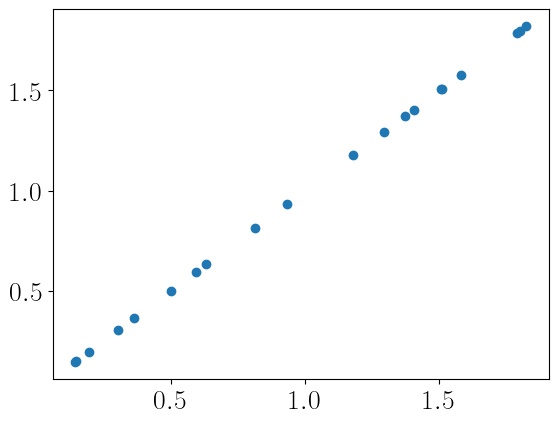

In [8]:
n_inp = 4
a = 1e-2
b = 2

# labels_train = linspace(a, b, 10)
# labels_train = concatenate([[a], np.sort(uniform(a, b, 19))])
labels_train = np.sort(uniform(a, b, 20))
svs_train = []
for p in labels_train:
    ham = ham_func(n_inp, p, *ham_args)
    svs_train.append(eigh(ham)[1][:,0])

labels_test = linspace(a, b, 20)
svs_test = []
for p in labels_test:
    ham = ham_func(n_inp, p, *ham_args)
    svs_test.append(eigh(ham)[1][:,0])

plt.scatter(labels_train, labels_train)

### Training

In [9]:
n_copies = 1
n_meas = n_inp*n_copies
n_tot = n_inp*n_copies
n_layers = 2

w_ls = 1e0
w_var = 1e-4

dp = 1e-5

x0 = concatenate([normal(pi/2, 0.1, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 0.01, 2**n_meas)])
# x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), uniform(-0.1, 0.1, 2**n_meas)])
# x0 = concatenate([normal(pi/2, 0.1, 2*n_tot*(n_layers + 1)), normal(0., 0.1, 2**n_meas)])
# x0 = concatenate([uniform(0, 2*pi, 2*n_tot*(n_layers + 1)), uniform(-1, 1, 2**n_meas)])
# x0 = array(pars)

save_path = r"/home/kardashin/Work/QPE/Results/Ising/"
file_info = r"Ising-pars-c=%d-m=%d-l=%d-w_ls=%f" %(n_copies, n_meas, n_layers, w_ls)
# x0 = np.load(save_path + file_info + r"-w_var=%f.npy" %(w_var))

time_start = time()
fvals, result = train_pure(svs_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method="BFGS", w_ls=w_ls, w_var=w_var, x0=x0)
time_finish = time() - time_start
print("\nFinished in", time_finish)
print("Cost:", result.fun)
print(result.message)
pars = result.x

Iteration: 5001 | Function value: 0.01619124
Finished in 194.31625890731812
Cost: 0.016191243134396023
Optimization terminated successfully.


In [10]:
expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train = aux_info(ham_func, labels_train, ham_args, n_inp, n_layers, pars, n_copies=n_copies, n_meas=n_meas, dp=dp)
biass_train = expecs_train - labels_train

n_inp: 4 | n_copies: 1 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 0.00019141735863582068


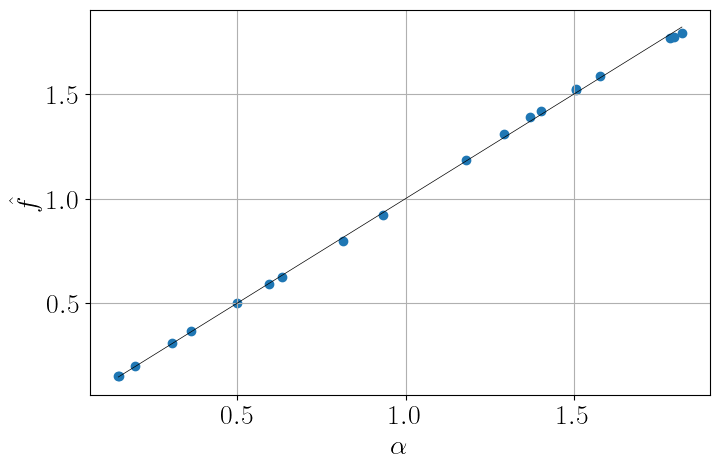

Sum var: 6.181447980839795
Difference: 0.16542188369588356
Least squares: 0.0441687848879931


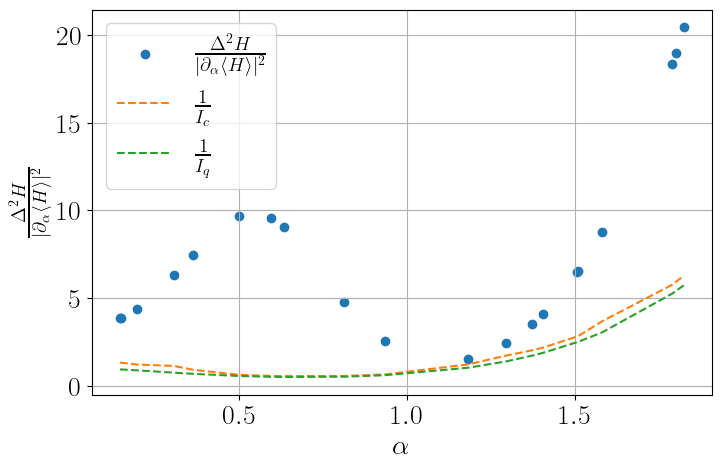

In [12]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nSum error:", sum(np.abs(labels_train - expecs_train)**2)/len(labels_train))

plt.figure(figsize=(8, 5))
plt.scatter(labels_train, expecs_train)
plt.plot(labels_train, labels_train, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{f}$")
# plt.legend()
plt.grid()
plt.show()

print("Sum var:", sum(disps_train)/len(CFIs_train))
print("Difference:", sum(np.abs(CFIs_train - QFIs_train))/len(CFIs_train))
print("Least squares:", sum((CFIs_train - QFIs_train)**2)/len(CFIs_train))

plt.figure(figsize=(8, 5))
plt.scatter(labels_train, disps_train/expecs_der_train**2, label=r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
# plt.scatter(ham_pars_train, disps_train, zorder=3, label=r"$\Delta^2 H$")
plt.plot(np.sort(labels_train), 1/CFIs_train, color="C1", label=r"$\frac{1}{I_c}$", linestyle="dashed")
plt.plot(np.sort(labels_train), 1/QFIs_train, color="C2", label=r"$\frac{1}{I_q}$", linestyle="dashed")
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
plt.show()

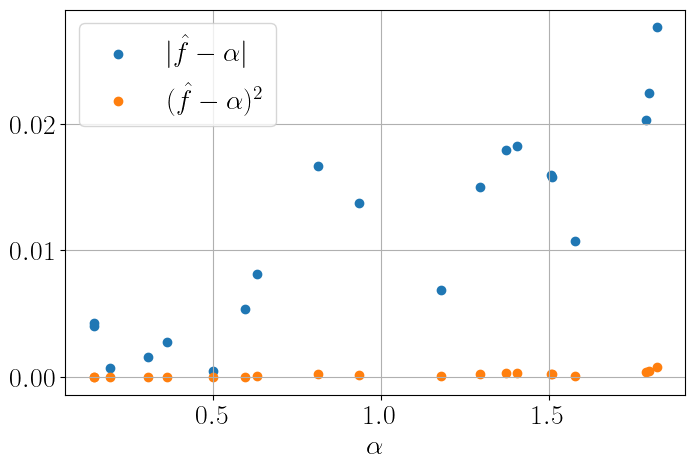

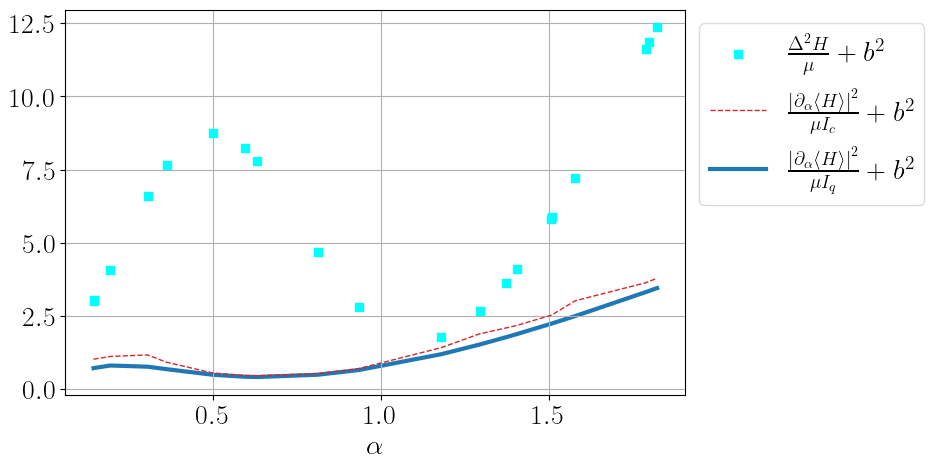

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(labels_train, np.abs(labels_train - expecs_train), label=r"$|\hat{f} - \alpha|$")
plt.scatter(labels_train, (labels_train - expecs_train)**2, label=r"$(\hat{f} - \alpha)^2$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.grid()
plt.show()

mu = 1e0

plt.figure(figsize=(8, 5))
plt.scatter(labels_train, disps_train/mu + biass_train**2, marker="s", color="cyan", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=4)
plt.plot(np.sort(labels_train), expecs_der_train**2/CFIs_train/mu + biass_train**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$", linewidth=1, color="tab:red", linestyle="dashed")
plt.plot(np.sort(labels_train), expecs_der_train**2/QFIs_train/mu + biass_train**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=3, color="tab:blue", zorder=0)
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

In [75]:
# np.save(r"/home/kardashin/Work/Quantum channel estimation/Results/Ising/Ising-pars-n=%d-c=%d-m=%d=l=%d-w_ls=%f-w_var=%f" %(n_qubits, n_copies, n_meas, n_layers, w_ls, w_var), pars)

### Testing

In [14]:
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test = aux_info(ham_func, labels_test, ham_args, n_inp, n_layers, pars,
                                                                          n_copies=n_copies, n_meas=n_meas, dp=dp)
biass_test = expecs_test - labels_test

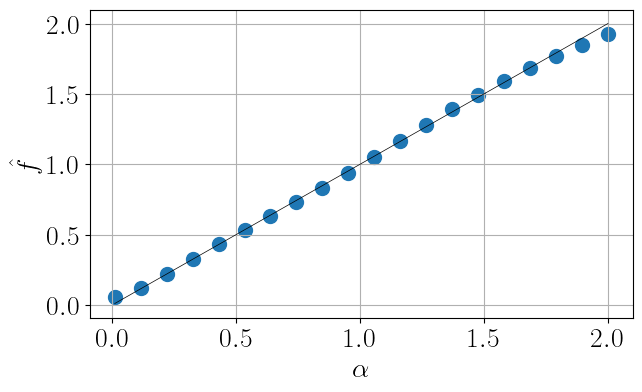

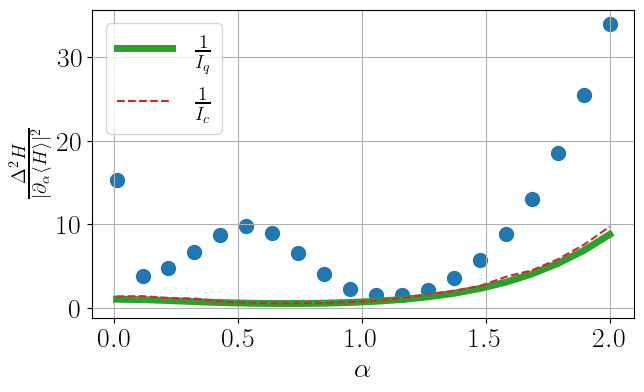

In [15]:
plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=100)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{f}$")
# plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test/expecs_der_test**2, s=100)
plt.plot(np.sort(labels_test), 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(np.sort(labels_test), 1/CFIs_test, color="C3", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
plt.show()

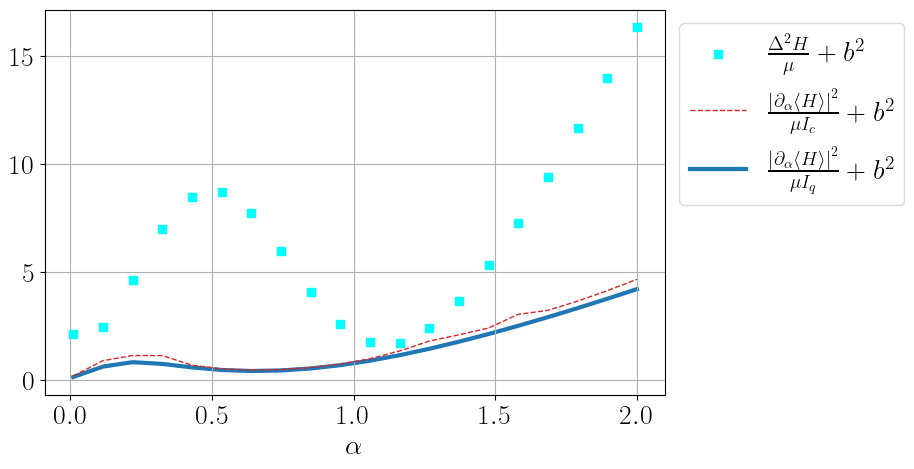

In [16]:
mu = 1e0

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, disps_test/mu + biass_test**2, marker="s", color="cyan", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=4)
plt.plot(np.sort(labels_test), expecs_der_test**2/CFIs_test/mu + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$", linewidth=1, color="tab:red", linestyle="dashed")
plt.plot(np.sort(labels_test), expecs_der_test**2/QFIs_test/mu + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=3, color="tab:blue", zorder=0)
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

### With measurements

In [26]:
n_shots = int(5000/n_copies)
n_est = 100

# preds_test, errors_test = estimate(ham_func, ham_pars_test, ham_args, pars, n_inp, n_layers,
#                                    n_copies=n_copies, n_meas=n_meas, n_shots=n_shots, n_est=n_est)
preds_test, errors_test = estimate_pure(svs_test, labels_test, n_layers, pars, 
                                        n_copies=n_copies, n_meas=n_meas, n_shots=n_shots, n_est=n_est)

n_inp: 4 | n_copies: 1 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 0.001970
Sum FI: 0.000179


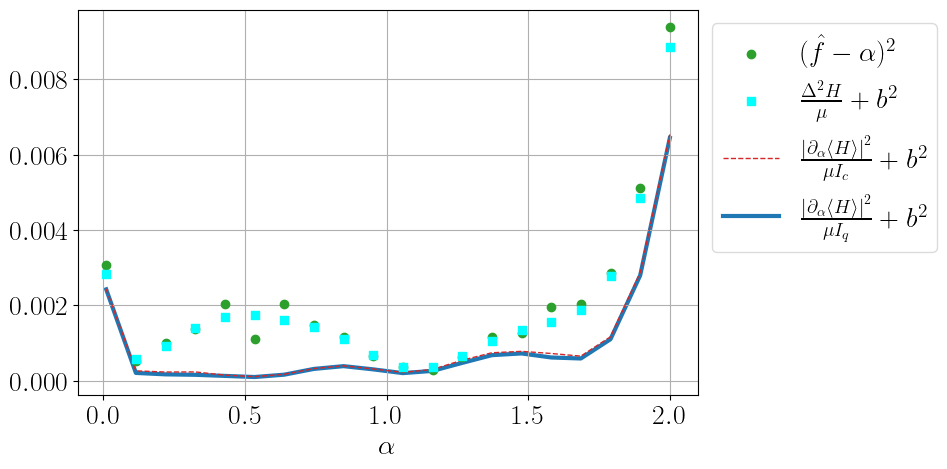

In [27]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
print("\nSum error: %f" %(sum(mean(errors_test, axis=0))/len(labels_test)))
print("Sum FI: %f" %(sum(CFIs_test)/len(labels_test)/n_shots))

plt.figure(figsize=(8, 5))
# plt.errorbar(ham_pars_test, y=mean(errors_test, axis=0), markersize=7, yerr=std(errors_test, axis=0), marker="o", capsize=3, linestyle="", label=r"$(\hat{f} - \alpha)^2$", color="tab:green", zorder=3)
plt.scatter(labels_test, mean(errors_test, axis=0), marker="o", label=r"$(\hat{f} - \alpha)^2$", color="tab:green", zorder=3)
plt.scatter(labels_test, disps_test/n_shots + biass_test**2, marker="s", color="cyan", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=4)
plt.plot(labels_test, expecs_der_test**2/CFIs_test/n_shots + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$", linewidth=1, color="tab:red", linestyle="dashed")
plt.plot(labels_test, expecs_der_test**2/QFIs_test/n_shots + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=3, color="tab:blue", zorder=0)
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

n_inp: 4 | n_copies: 1 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.001970
Sum FI: 0.000179


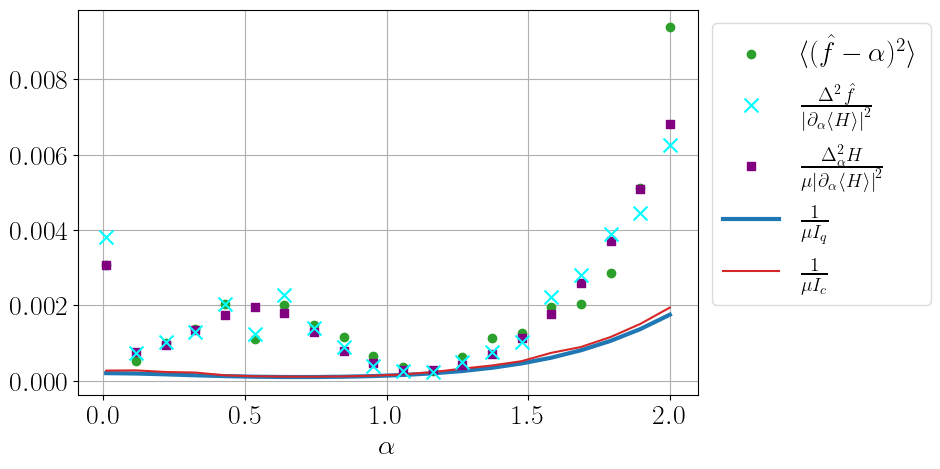

In [28]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("Sum error: %f" %(sum(mean(errors_test, axis=0))/len(labels_test)))
print("Sum FI: %f" %(sum(CFIs_test)/len(labels_test)/n_shots))
plt.figure(figsize=(8, 5))

biass_test = expecs_test - labels_test

# plt.errorbar(ham_pars_test, y=mean(errors_test, axis=0), markersize=7, yerr=std(errors_test, axis=0), marker="o", capsize=3, linestyle="", label=r"$(\hat{f} - \alpha)^2$", color="tab:green", zorder=3)
plt.scatter(labels_test, mean(errors_test, axis=0), marker="o", label=r"$\langle(\hat{f} - \alpha)^2\rangle$", color="tab:green", zorder=3)
plt.scatter(labels_test, np.var(preds_test, axis=0)/expecs_der_test**2, zorder=5, marker="x", s=100, color="cyan", label=r"$\frac{\Delta^2\,\hat{f}}{\left| \partial_\alpha \langle H \rangle \right|^2}$")
plt.scatter(labels_test, disps_test/np.abs(array(expecs_der_test))**2/n_shots, zorder=3, marker="s", color="purple", label=r"$\frac{\Delta^2_\alpha H}{\mu \left| \partial_\alpha \langle H \rangle \right|^2}$")
plt.plot(labels_test, 1/QFIs_test/n_shots, label=r"$\frac{1}{\mu I_q}$", linewidth=3, color="tab:blue")
plt.plot(labels_test, 1/CFIs_test/n_shots, label=r"$\frac{1}{\mu I_c}$", linewidth=1.5, color="tab:red")

plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

### Bias compensation

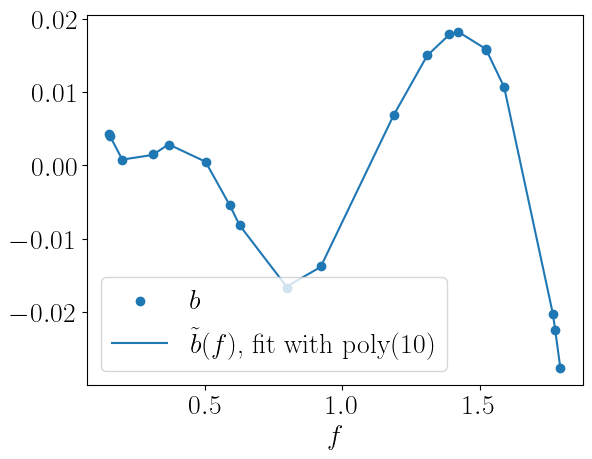

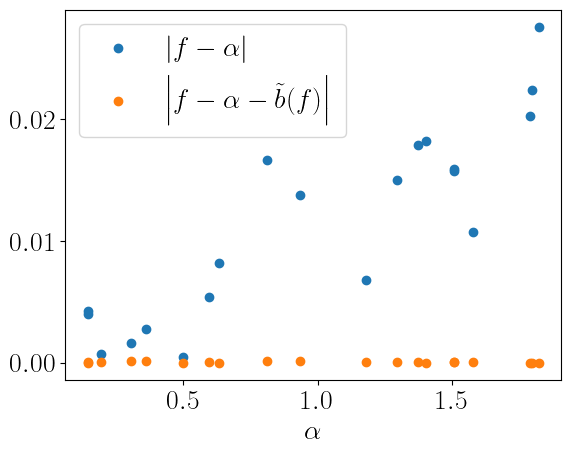

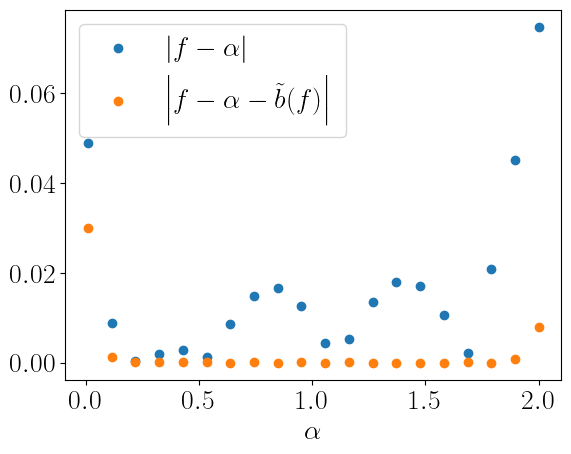

In [30]:
m = 10
f_bias = np.poly1d(np.polyfit(expecs_train, biass_train, m))

plt.scatter(expecs_train, biass_train, label=r"$b$")
plt.plot(expecs_train, f_bias(expecs_train), label=r"$\tilde{b}(f)$, fit with $\mathrm{poly}(%d)$"%(m))
plt.xlabel(r"$f$")# = \langle H \rangle_{\rho_\alpha}$")
# plt.ylabel(r"$b(\alpha)$")
plt.legend()
plt.show()

plt.scatter(labels_train, np.abs(expecs_train - labels_train),  label=r"$|f - \alpha|$")
plt.scatter(labels_train, np.abs(expecs_train - labels_train - f_bias(expecs_train)),  label=r"$\left|f - \alpha - \tilde{b}(f)\right|$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

plt.scatter(labels_test, np.abs(expecs_test - labels_test),  label=r"$|f - \alpha|$")
plt.scatter(labels_test, np.abs(expecs_test - labels_test - f_bias(expecs_test)),  label=r"$\left|f - \alpha - \tilde{b}(f)\right|$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

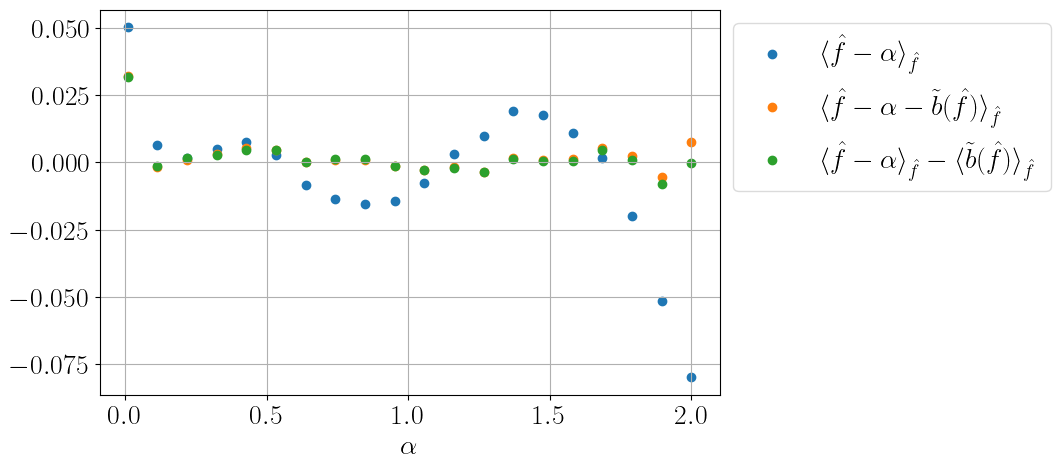

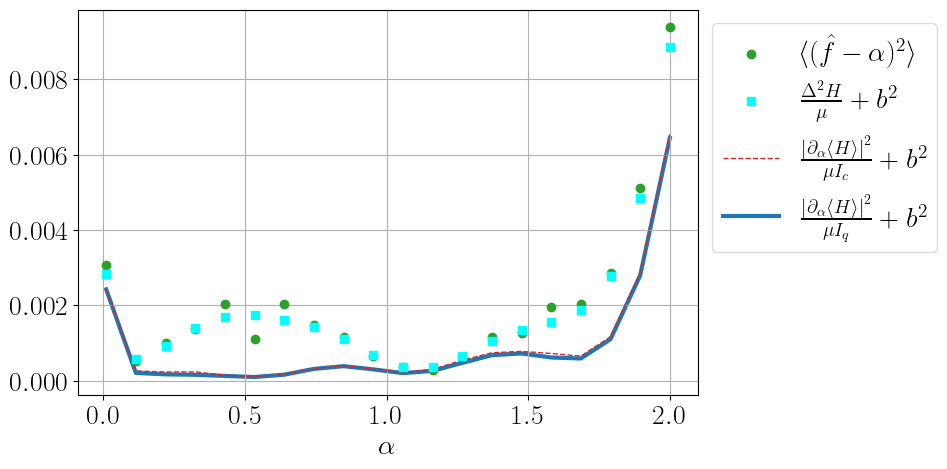

In [31]:
preds_test_mean = mean(preds_test, axis=0)

plt.figure(figsize=(8, 5))
plt.scatter(labels_test, mean(preds_test - labels_test, axis=0), marker="o", label=r"$\langle\hat{f} - \alpha\rangle_{\hat{f}}$")
plt.scatter(labels_test, mean(preds_test - labels_test - f_bias(preds_test), axis=0), marker="o", label=r"$\langle\hat{f} - \alpha - \tilde{b}(\hat{f})\rangle_{\hat{f}}$")
plt.scatter(labels_test, mean(preds_test - labels_test, axis=0) - f_bias(preds_test_mean), marker="o", label=r"$\langle\hat{f} - \alpha\rangle_{\hat{f}} - \langle\tilde{b}(\hat{f})\rangle_{\hat{f}}$")
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()


plt.figure(figsize=(8, 5))
# plt.errorbar(ham_pars_test, y=mean(errors_test, axis=0), markersize=7, yerr=std(errors_test, axis=0), marker="o", capsize=3, linestyle="", label=r"$(\hat{f} - \alpha)^2$", color="tab:green", zorder=3)
plt.scatter(labels_test, mean(errors_test, axis=0), marker="o", label=r"$\langle(\hat{f} - \alpha)^2\rangle$", color="tab:green", zorder=3)
plt.scatter(labels_test, disps_test/n_shots + biass_test**2, marker="s", color="cyan", label=r"$\frac{\Delta^2 H}{\mu} + b^2$", zorder=4)
plt.plot(labels_test, expecs_der_test**2/CFIs_test/n_shots + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_c} + b^2$", linewidth=1, color="tab:red", linestyle="dashed")
plt.plot(labels_test, expecs_der_test**2/QFIs_test/n_shots + biass_test**2, label=r"$\frac{\left| \partial_\alpha \langle H \rangle \right|^2}{\mu I_q} + b^2$", linewidth=3, color="tab:blue", zorder=0)
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

n_inp: 4 | n_copies: 1 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.001970
Sum FI: 0.000179


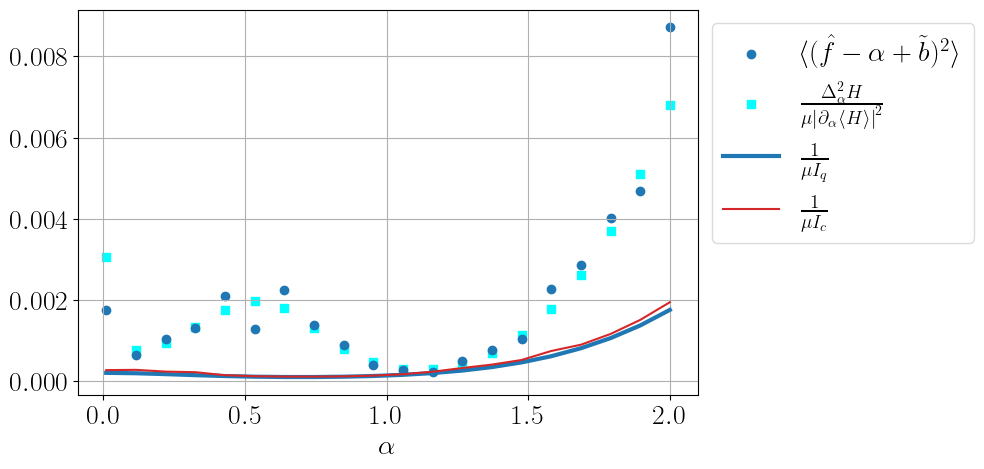

In [32]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("Sum error: %f" %(sum(mean(errors_test, axis=0))/len(labels_test)))
print("Sum FI: %f" %(sum(CFIs_test)/len(labels_test)/n_shots))
plt.figure(figsize=(8, 5))

plt.scatter(labels_test, mean((preds_test - labels_test - f_bias(preds_test))**2, axis=0), marker="o", label=r"$\langle(\hat{f} - \alpha + \tilde{b})^2\rangle$")
# plt.scatter(labels_test, np.var(preds_test, axis=0)/expecs_der_test**2, zorder=5, marker="x", s=100, color="cyan", label=r"$\frac{\Delta^2\,\hat{f}}{\left| \partial_\alpha \langle H \rangle \right|^2}$")
plt.scatter(labels_test, disps_test/np.abs(array(expecs_der_test))**2/n_shots, zorder=0, marker="s", color="cyan", label=r"$\frac{\Delta^2_\alpha H}{\mu \left| \partial_\alpha \langle H \rangle \right|^2}$")
plt.plot(labels_test, 1/QFIs_test/n_shots, label=r"$\frac{1}{\mu I_q}$", linewidth=3, color="tab:blue")
plt.plot(labels_test, 1/CFIs_test/n_shots, label=r"$\frac{1}{\mu I_c}$", linewidth=1.5, color="tab:red")

plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=0.7, ncol=1, bbox_to_anchor=(1.0, 1))#
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()

### Inversion

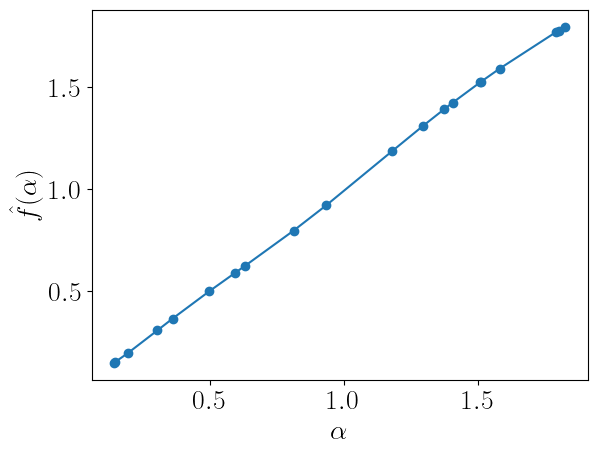

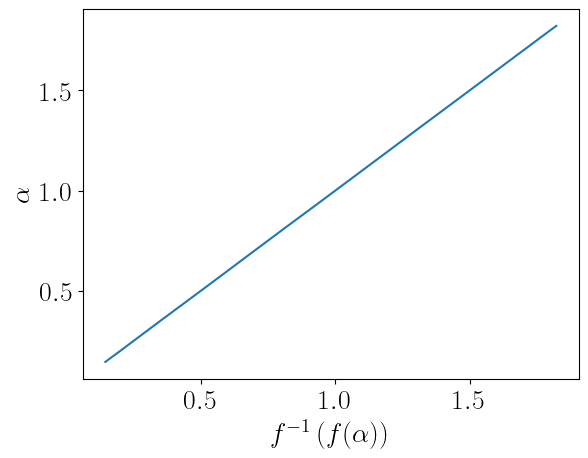

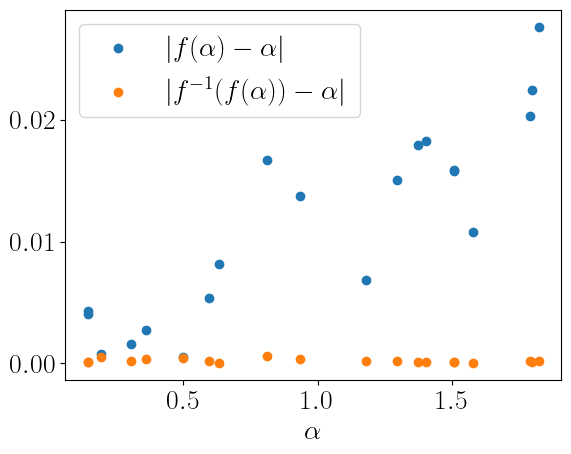

In [33]:
m = 8
f = np.poly1d(np.polyfit(labels_train, expecs_train, m))
f_inv = np.poly1d(np.polyfit(expecs_train, labels_train, m))

plt.scatter(labels_train, expecs_train, label=r"$\hat{\alpha}$")
plt.plot(labels_train, f(labels_train))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\hat{f}(\alpha)$")
# plt.legend()
plt.show()

plt.plot(f_inv(expecs_train), labels_train, label="")
plt.xlabel(r"$f^{-1}\left(f(\alpha)\right)$")
plt.ylabel(r"$\alpha$")
# plt.legend()
plt.show()

# plt.ylabel(r"$|\hat{\alpha} - \alpha|$")
plt.scatter(labels_train, np.abs(labels_train - expecs_train),  label=r"$|f(\alpha) - \alpha|$")
plt.scatter(labels_train, np.abs(labels_train - f_inv(expecs_train)), label=r"$|f^{-1}(f(\alpha)) - \alpha|$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

m: 8 | n_inp: 4 | n_copies: 1 | n_meas: 4 | n_layers: 2 
n_shots: 5000 | n_est: 100
Sum error: 0.001970
Sum cFI: 0.000179
Diff CR: 0.000062


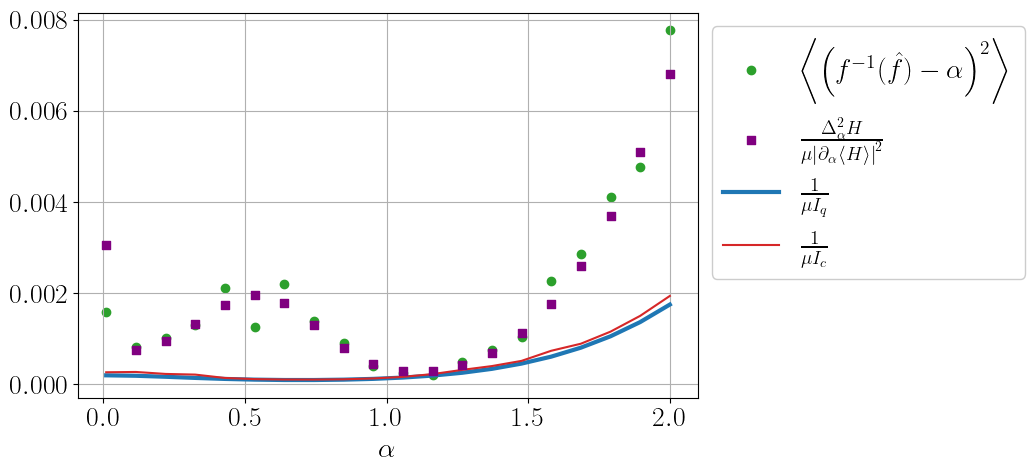

In [34]:
print("m: %d | n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(m, n_inp, n_copies, n_meas, n_layers))
print("n_shots: %d | n_est: %d" %(n_shots, n_est))

print("Sum error: %f" %(sum(mean(errors_test, axis=0))/len(labels_test)))
print("Sum cFI: %f" %(sum(CFIs_test)/len(labels_test)/n_shots))
print("Diff CR: %f" %(sum(1/array(CFIs_test) - 1/array(QFIs_test)) /len(labels_test)/n_shots))
plt.figure(figsize=(8, 5))


plt.scatter(labels_test, mean((f_inv(preds_test) - labels_test)**2, axis=0), color="tab:green", label=r"$\left\langle \left(f^{-1}(\hat{f}) - \alpha\right)^2 \right\rangle$")
# plt.errorbar(labels_test, y=mean((f_inv(preds_test) - labels_test)**2, axis=0), color="tab:green", markersize=7, yerr=std((f_inv(preds_test) - labels_test)**2, axis=0), marker="o", capsize=3, linestyle="", label=r"$\Delta^2\,f^{-1}\left(\hat{f}(\alpha)\right)$")
# plt.scatter(ham_pars_test, (f_inv(mean(preds_test, axis=0)) - ham_pars_test)**2, label=r"$\Delta^2\,f^{-1}\left(\hat{f}(\alpha)\right)$")
plt.scatter(labels_test, disps_test/np.abs(array(expecs_der_test))**2/n_shots, zorder=3, marker="s", color="purple", label=r"$\frac{\Delta^2_\alpha H}{\mu \left| \partial_\alpha \langle H \rangle \right|^2}$")
# plt.scatter(channel_pars_test, (mean(((preds_test) - channel_pars_test)**2, axis=0)))
# plt.scatter(ham_pars_test, np.var(preds_test, axis=0)/np.abs(array(expecs_der_test))**2, zorder=5, marker="x", s=100, color="cyan", label=r"$\frac{\Delta^2\,\hat{f}}{\left| \partial_\alpha \langle H \rangle \right|^2}$")
plt.plot(labels_test, 1/QFIs_test/n_shots, label=r"$\frac{1}{\mu I_q}$", linewidth=3, color="tab:blue")
plt.plot(labels_test, 1/CFIs_test/n_shots, label=r"$\frac{1}{\mu I_c}$", linewidth=1.5, color="tab:red")

plt.xlabel(r"$\alpha$")
# plt.ylabel(r"$(\tilde{\alpha} - \alpha)^2$" )
# plt.ylabel(r"$\mathrm{Var}\,\hat{f}(\alpha)$" )
plt.grid()
# plt.yscale("log")
plt.legend(framealpha=1, ncol=1, bbox_to_anchor=(1., 1))
# plt.savefig("c="+str(n_copies) + "-e="+str(n_ext) + "-l="+str(n_layers) + "-w_ls="+str(w_ls) + "-w_var="+str(w_var) + "-all-" + channel_name + ".pdf", bbox_inches='tight')
plt.show()